In [194]:
# Do not change this cell
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 1

# Create dataset
X, y = make_blobs(n_samples=10000, n_features=num_features, centers=num_classes, 
                  cluster_std=1.5, random_state=random_seed)

# Convert to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [195]:
torch.multiprocessing.set_start_method('spawn', force=True)

In [196]:
# TODO: you will design your model here
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        # TODO: implement this method
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        # TODO: implement this method
        if x is None:
            return x
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

In [197]:
def train_step(model, X_train, y_train, loss_fn, optimizer, device):
    model.train()
    
    X_train, y_train = X_train.to(device), y_train.to(device)
    
    # Forward pass
    outputs = model(X_train)
    
    # Ensure y_train is LongTensor
    y_train = y_train.type(torch.LongTensor).to(device)
    
    loss = loss_fn(outputs, y_train)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_train).sum().item()
    accuracy = correct / len(y_train)
    
    return loss.item(), accuracy

In [198]:
def evaluation_step(model, X_test, y_test, loss_fn, device):
    model.eval()
    
    X_test, y_test = X_test.to(device), y_test.to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(X_test)
    
    # Ensure y_test is LongTensor
    y_test = y_test.type(torch.LongTensor).to(device)
    
    loss = loss_fn(outputs, y_test).item()
    
    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test).sum().item()
    accuracy = correct / len(y_test)
    
    return loss, accuracy

In [234]:
def train_simple_model(X_train, y_train, X_test, y_test, random_seed):
    # Make device
    device = "cpu" 
    if torch.cuda.is_available(): 
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps" 
    
    torch.manual_seed(random_seed)  # do not change this

    # Initialize the model
    model = SimpleModel(input_size=num_features, output_size=num_classes)
    model.to(device)
    
    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    
    num_epochs = 600
    train_losses = []  # Initialize list to store training losses
    train_accuracies = []  # Initialize list to store training accuracies
    test_losses = []  # Initialize list to store test losses
    test_accuracies = []  # Initialize list to store test accuracies

    for epoch in range(num_epochs):
            # Training step
            train_loss, train_accuracy = train_step(model, X_train, y_train, loss_fn, optimizer, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Evaluation step
            test_loss, test_accuracy = evaluation_step(model, X_test, y_test, loss_fn, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

In [235]:
# TODO: plot accuracy curves
def plot_accuracy_performance(train_accuracies, test_accuracies):
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.title('Accuracy Curve')
    
    plt.legend()
    plt.show()

In [236]:
# TODO: plot loss curves
def plot_loss_performance(train_losses, test_losses):
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Loss Curve')
   
    plt.legend()
    plt.show()

In [237]:
def plot_decision_boundary(model, X_train, y_train):
    # Move model to CPU if it's on CUDA
    model.to("cpu")

    # Move data to CPU if it's on CUDA
    X_train_cpu, y_train_cpu = X_train.cpu(), y_train.cpu()

    # Plotting decision boundary requires meshgrid
    x_min, x_max = X_train_cpu[:, 0].min() - 1, X_train_cpu[:, 0].max() + 1
    y_min, y_max = X_train_cpu[:, 1].min() - 1, X_train_cpu[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    mesh_input = np.c_[xx.ravel(), yy.ravel()]
    mesh_input = torch.from_numpy(mesh_input).type(torch.float)
    
    Z = model(mesh_input).detach().cpu().numpy()
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)

    scatter = plt.scatter(X_train_cpu[:, 0], X_train_cpu[:, 1], c=y_train_cpu, cmap=plt.cm.Paired, edgecolors='k')
    
    # Legend
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

In [238]:
# Do not change this cell
model, train_losses, train_accuracies, test_losses, test_accuracies\
    = train_simple_model(X_train, y_train, X_test, y_test, random_seed)

Epoch 1/600, Training Loss: 2.2380, Training Accuracy: 0.2530, Test Loss: 5.3042, Test Accuracy: 0.6530
Epoch 2/600, Training Loss: 5.5557, Training Accuracy: 0.6320, Test Loss: 4.5591, Test Accuracy: 0.5010
Epoch 3/600, Training Loss: 4.6334, Training Accuracy: 0.4985, Test Loss: 6.0027, Test Accuracy: 0.4950
Epoch 4/600, Training Loss: 6.1298, Training Accuracy: 0.4839, Test Loss: 1.8602, Test Accuracy: 0.6175
Epoch 5/600, Training Loss: 1.8191, Training Accuracy: 0.6282, Test Loss: 1.2221, Test Accuracy: 0.7405
Epoch 6/600, Training Loss: 1.2794, Training Accuracy: 0.7222, Test Loss: 0.6355, Test Accuracy: 0.7300
Epoch 7/600, Training Loss: 0.6522, Training Accuracy: 0.7157, Test Loss: 0.5402, Test Accuracy: 0.7805
Epoch 8/600, Training Loss: 0.5479, Training Accuracy: 0.7782, Test Loss: 0.5534, Test Accuracy: 0.7360
Epoch 9/600, Training Loss: 0.5753, Training Accuracy: 0.7199, Test Loss: 0.6497, Test Accuracy: 0.6735
Epoch 10/600, Training Loss: 0.6448, Training Accuracy: 0.6890, 

Epoch 93/600, Training Loss: 0.4035, Training Accuracy: 0.7939, Test Loss: 0.3785, Test Accuracy: 0.8555
Epoch 94/600, Training Loss: 0.3816, Training Accuracy: 0.8546, Test Loss: 0.3830, Test Accuracy: 0.8095
Epoch 95/600, Training Loss: 0.4025, Training Accuracy: 0.7949, Test Loss: 0.3771, Test Accuracy: 0.8550
Epoch 96/600, Training Loss: 0.3802, Training Accuracy: 0.8555, Test Loss: 0.3819, Test Accuracy: 0.8105
Epoch 97/600, Training Loss: 0.4014, Training Accuracy: 0.7954, Test Loss: 0.3757, Test Accuracy: 0.8550
Epoch 98/600, Training Loss: 0.3788, Training Accuracy: 0.8561, Test Loss: 0.3808, Test Accuracy: 0.8120
Epoch 99/600, Training Loss: 0.4003, Training Accuracy: 0.7969, Test Loss: 0.3744, Test Accuracy: 0.8560
Epoch 100/600, Training Loss: 0.3775, Training Accuracy: 0.8562, Test Loss: 0.3798, Test Accuracy: 0.8125
Epoch 101/600, Training Loss: 0.3993, Training Accuracy: 0.7980, Test Loss: 0.3731, Test Accuracy: 0.8560
Epoch 102/600, Training Loss: 0.3761, Training Accura

Epoch 182/600, Training Loss: 0.3393, Training Accuracy: 0.8741, Test Loss: 0.3477, Test Accuracy: 0.8310
Epoch 183/600, Training Loss: 0.3669, Training Accuracy: 0.8267, Test Loss: 0.3357, Test Accuracy: 0.8690
Epoch 184/600, Training Loss: 0.3386, Training Accuracy: 0.8742, Test Loss: 0.3471, Test Accuracy: 0.8310
Epoch 185/600, Training Loss: 0.3662, Training Accuracy: 0.8273, Test Loss: 0.3350, Test Accuracy: 0.8695
Epoch 186/600, Training Loss: 0.3379, Training Accuracy: 0.8748, Test Loss: 0.3464, Test Accuracy: 0.8325
Epoch 187/600, Training Loss: 0.3655, Training Accuracy: 0.8277, Test Loss: 0.3343, Test Accuracy: 0.8705
Epoch 188/600, Training Loss: 0.3372, Training Accuracy: 0.8752, Test Loss: 0.3457, Test Accuracy: 0.8345
Epoch 189/600, Training Loss: 0.3648, Training Accuracy: 0.8285, Test Loss: 0.3335, Test Accuracy: 0.8705
Epoch 190/600, Training Loss: 0.3365, Training Accuracy: 0.8758, Test Loss: 0.3450, Test Accuracy: 0.8345
Epoch 191/600, Training Loss: 0.3641, Training

Epoch 270/600, Training Loss: 0.3144, Training Accuracy: 0.8826, Test Loss: 0.3226, Test Accuracy: 0.8520
Epoch 271/600, Training Loss: 0.3409, Training Accuracy: 0.8427, Test Loss: 0.3109, Test Accuracy: 0.8830
Epoch 272/600, Training Loss: 0.3139, Training Accuracy: 0.8828, Test Loss: 0.3221, Test Accuracy: 0.8525
Epoch 273/600, Training Loss: 0.3403, Training Accuracy: 0.8435, Test Loss: 0.3104, Test Accuracy: 0.8830
Epoch 274/600, Training Loss: 0.3135, Training Accuracy: 0.8828, Test Loss: 0.3217, Test Accuracy: 0.8540
Epoch 275/600, Training Loss: 0.3399, Training Accuracy: 0.8438, Test Loss: 0.3099, Test Accuracy: 0.8825
Epoch 276/600, Training Loss: 0.3130, Training Accuracy: 0.8832, Test Loss: 0.3213, Test Accuracy: 0.8540
Epoch 277/600, Training Loss: 0.3394, Training Accuracy: 0.8441, Test Loss: 0.3095, Test Accuracy: 0.8830
Epoch 278/600, Training Loss: 0.3126, Training Accuracy: 0.8832, Test Loss: 0.3208, Test Accuracy: 0.8540
Epoch 279/600, Training Loss: 0.3389, Training

Epoch 359/600, Training Loss: 0.3213, Training Accuracy: 0.8571, Test Loss: 0.2934, Test Accuracy: 0.8890
Epoch 360/600, Training Loss: 0.2967, Training Accuracy: 0.8899, Test Loss: 0.3032, Test Accuracy: 0.8640
Epoch 361/600, Training Loss: 0.3209, Training Accuracy: 0.8572, Test Loss: 0.2931, Test Accuracy: 0.8895
Epoch 362/600, Training Loss: 0.2964, Training Accuracy: 0.8898, Test Loss: 0.3028, Test Accuracy: 0.8640
Epoch 363/600, Training Loss: 0.3205, Training Accuracy: 0.8574, Test Loss: 0.2927, Test Accuracy: 0.8895
Epoch 364/600, Training Loss: 0.2960, Training Accuracy: 0.8898, Test Loss: 0.3024, Test Accuracy: 0.8640
Epoch 365/600, Training Loss: 0.3201, Training Accuracy: 0.8576, Test Loss: 0.2924, Test Accuracy: 0.8895
Epoch 366/600, Training Loss: 0.2957, Training Accuracy: 0.8901, Test Loss: 0.3020, Test Accuracy: 0.8645
Epoch 367/600, Training Loss: 0.3197, Training Accuracy: 0.8579, Test Loss: 0.2921, Test Accuracy: 0.8895
Epoch 368/600, Training Loss: 0.2954, Training

Epoch 452/600, Training Loss: 0.2823, Training Accuracy: 0.8940, Test Loss: 0.2863, Test Accuracy: 0.8740
Epoch 453/600, Training Loss: 0.3033, Training Accuracy: 0.8681, Test Loss: 0.2785, Test Accuracy: 0.8975
Epoch 454/600, Training Loss: 0.2821, Training Accuracy: 0.8941, Test Loss: 0.2860, Test Accuracy: 0.8745
Epoch 455/600, Training Loss: 0.3030, Training Accuracy: 0.8684, Test Loss: 0.2783, Test Accuracy: 0.8975
Epoch 456/600, Training Loss: 0.2818, Training Accuracy: 0.8942, Test Loss: 0.2858, Test Accuracy: 0.8745
Epoch 457/600, Training Loss: 0.3027, Training Accuracy: 0.8686, Test Loss: 0.2781, Test Accuracy: 0.8980
Epoch 458/600, Training Loss: 0.2816, Training Accuracy: 0.8942, Test Loss: 0.2856, Test Accuracy: 0.8745
Epoch 459/600, Training Loss: 0.3025, Training Accuracy: 0.8686, Test Loss: 0.2778, Test Accuracy: 0.8980
Epoch 460/600, Training Loss: 0.2814, Training Accuracy: 0.8942, Test Loss: 0.2853, Test Accuracy: 0.8745
Epoch 461/600, Training Loss: 0.3023, Training

Epoch 540/600, Training Loss: 0.2727, Training Accuracy: 0.8964, Test Loss: 0.2748, Test Accuracy: 0.8800
Epoch 541/600, Training Loss: 0.2914, Training Accuracy: 0.8735, Test Loss: 0.2688, Test Accuracy: 0.9000
Epoch 542/600, Training Loss: 0.2725, Training Accuracy: 0.8965, Test Loss: 0.2747, Test Accuracy: 0.8800
Epoch 543/600, Training Loss: 0.2912, Training Accuracy: 0.8738, Test Loss: 0.2687, Test Accuracy: 0.9000
Epoch 544/600, Training Loss: 0.2723, Training Accuracy: 0.8968, Test Loss: 0.2745, Test Accuracy: 0.8800
Epoch 545/600, Training Loss: 0.2910, Training Accuracy: 0.8738, Test Loss: 0.2685, Test Accuracy: 0.9000
Epoch 546/600, Training Loss: 0.2722, Training Accuracy: 0.8969, Test Loss: 0.2743, Test Accuracy: 0.8805
Epoch 547/600, Training Loss: 0.2908, Training Accuracy: 0.8739, Test Loss: 0.2683, Test Accuracy: 0.9000
Epoch 548/600, Training Loss: 0.2720, Training Accuracy: 0.8970, Test Loss: 0.2741, Test Accuracy: 0.8810
Epoch 549/600, Training Loss: 0.2906, Training

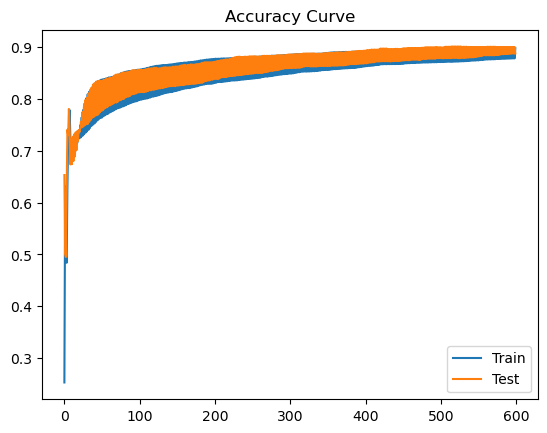

In [239]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, test_accuracies)

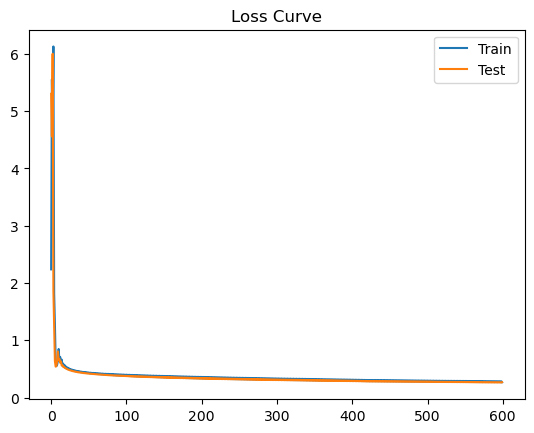

In [240]:
# Do not change this cell
plot_loss_performance(train_losses, test_losses)

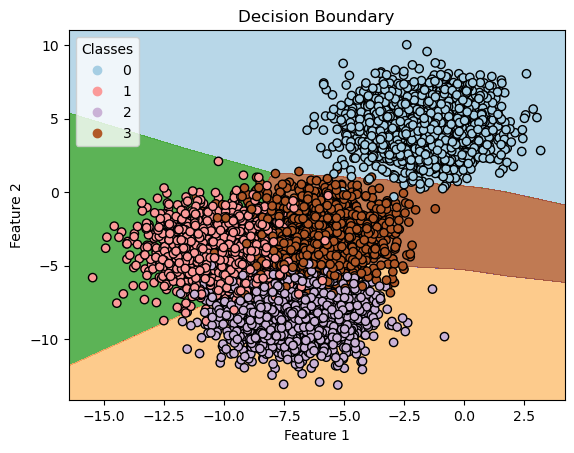

In [241]:
# Do not change this cell
plot_decision_boundary(model, X_train, y_train)